In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('../')

In [3]:
from yaml import load as yaml_load
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import pandas as pd
import scipy.stats as st
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from src.features.build_features import extract_features_classification
from src.data.make_dataset import LoadDataframe
from src.models.train_model import model_classification

Using TensorFlow backend.


In [5]:
def _load_config_file(config_file):
    """
    Load configuration file
    :param config_file: is the configuration file
    :return: configuration
    :rtype: dict
    """
    with open(config_file) as yml_config:
        return yaml_load(yml_config)

def _build_configuration(config_file):
    """
    Build the operation configuration dict
    :param config_file: is the path to the yaml config_file
    :type: string
    :return: config: global configuration
    :rtype dict
    """
    # yaml config
    config = _load_config_file(config_file)
    return config

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.figure(figsize=(15, 15))

In [6]:
config_file = "/home/ml/Documents/crimes_chigaco/config/config.yml"
config = _build_configuration(config_file)

In [7]:
%%time
obj_df_loaded = LoadDataframe(config, '2013', '2014')

CPU times: user 672 µs, sys: 77 µs, total: 749 µs
Wall time: 754 µs


In [8]:
%%time
df_crime_socio = obj_df_loaded.df_crime_socio()

CPU times: user 13min 5s, sys: 2.26 s, total: 13min 7s
Wall time: 15min 23s


In [9]:
df_crime_socio.sample(5).T

,200368,182242,121924,164695,147852
id,9278516,9249524,9153346,9220544,9195132
cas_number,HW423406,HW395308,HW298368,HW362148,HW340086
date,2013-08-23 20:13:00,2013-08-05 23:00:00,2013-05-31 12:20:00,2013-07-14 03:00:00,2013-06-29 00:44:00
block,068XX S LOWE AVE,043XX W MONROE ST,011XX S WESTERN AVE,054XX S KIMBARK AVE,071XX S HARVARD AVE
iucr,2830,0890,1330,0810,1310
primary_type,OTHER OFFENSE,THEFT_ROBBERY_BURGLARY,CRIMINAL TRESPASS,THEFT_ROBBERY_BURGLARY,CRIMINAL DAMAGE
description,OBSCENE TELEPHONE CALLS,FROM BUILDING,TO LAND,OVER $500,TO PROPERTY
location_description,APARTMENT,RESIDENCE,OTHER,STREET,APARTMENT
arrest,False,False,True,False,False
domestic,False,False,False,False,False


In [10]:
df_crime_socio['block'].sample(5)

242132       001XX N KEDZIE AVE
33156       046XX W MAYPOLE AVE
288984        008XX N OGDEN AVE
179543    054XX W FULLERTON AVE
107293        022XX W THOMAS ST
Name: block, dtype: object

In [11]:
df_temperature = obj_df_loaded.df_temperature()

In [12]:
df_temperature.sample(5)

,Temperature,month,day,hours
8299,296.150000,9,12,7
9437,282.465000,10,29,17
9290,277.656667,10,23,14
4974,281.570000,4,26,18
4668,277.560000,4,14,0


In [13]:
df_sky = obj_df_loaded.df_sky()

In [14]:
df_sky.sample(5).T

,8902,8238,8217,10521,8625
Chicago_broken clouds,1,0,1,1,0
Chicago_drizzle,0,0,0,0,0
Chicago_dust,0,0,0,0,0
Chicago_few clouds,0,0,0,0,0
Chicago_fog,0,0,0,0,0
Chicago_freezing rain,0,0,0,0,0
Chicago_haze,0,0,0,0,0
Chicago_heavy intensity drizzle,0,0,0,0,0
Chicago_heavy intensity rain,0,0,0,0,0
Chicago_heavy snow,0,0,0,0,0


In [15]:
obj_features = extract_features_classification(config, df_crime_socio, df_temperature, df_sky)

In [16]:
df_ml = obj_features.extract_feature()

In [17]:
obj_model = model_classification(config, df_ml)

In [18]:
list_data = obj_model.load_for_ml()
X_train = list_data[0]
x_test = list_data[1]
y_train = list_data[2] 
y_test = list_data[3]
class_names = list_data[4]

In [19]:
class_names

['ASSAULT_BATTERY', 'NARCOTICS', 'THEFT_ROBBERY_BURGLARY']

In [19]:
gboost_param_classification = {
    "n_estimators": st.randint(100, 200),
    "max_depth": st.randint(5,20),
    "gamma": [5,15]}

In [20]:
model_xgboost = obj_model.train_xgboost_(params= gboost_param_classification)

In [21]:
preds = model_xgboost.predict(x_test)

In [22]:
print(precision_score(y_test, preds, average='macro'))

0.7027219106141418


In [23]:
print(accuracy_score(y_test, preds))

0.712966537966538


Confusion matrix, without normalization
[[11618  2183  7727]
 [ 1009  6381  2852]
 [ 2164  1907 26319]]
Normalized confusion matrix
[[0.54 0.1  0.36]
 [0.1  0.62 0.28]
 [0.07 0.06 0.87]]


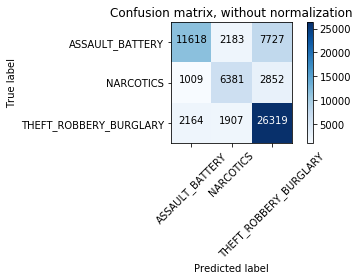

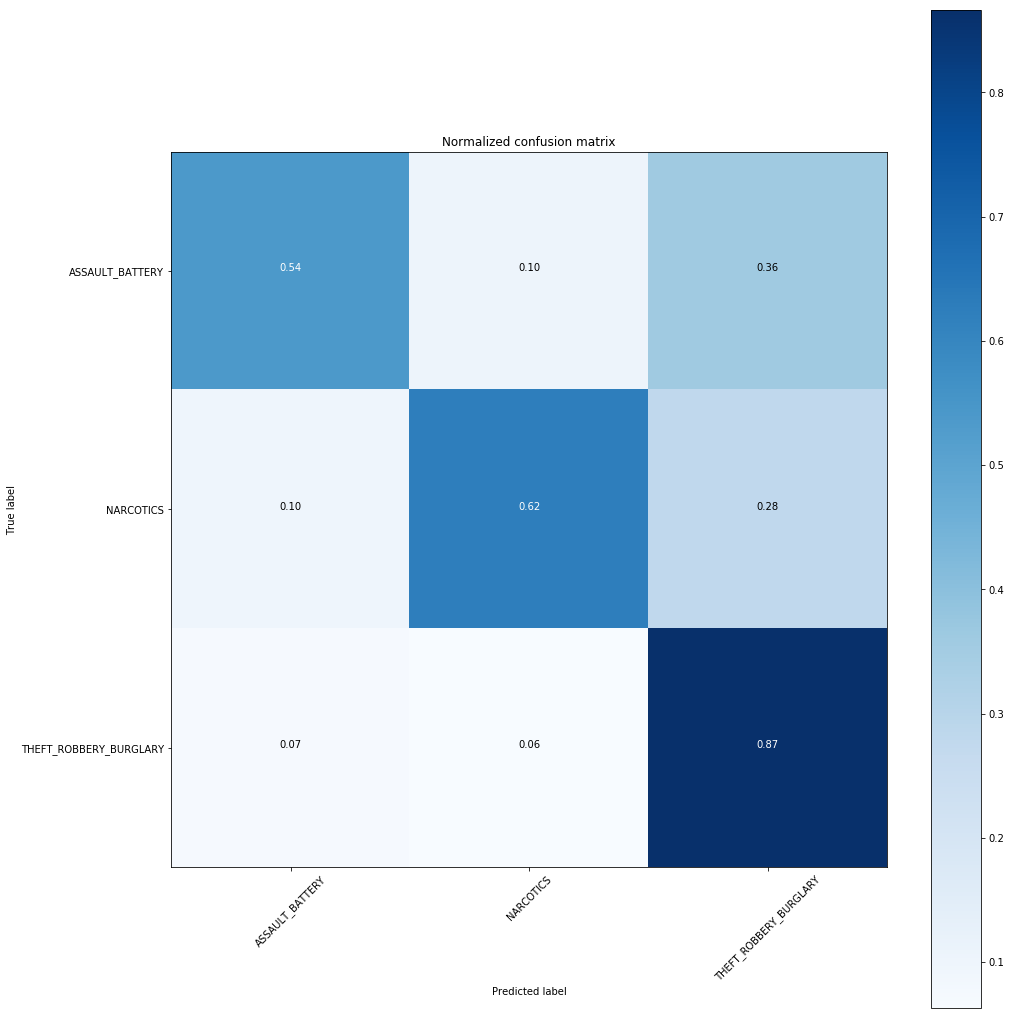

<Figure size 1080x1080 with 0 Axes>

In [24]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds) 
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figsize = (10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figsize = (10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

###  Save model

In [25]:
filename = '/home/ml/Documents/crimes_chigaco/models/model_xgboost_2013_2014.sav'

In [26]:
joblib.dump(model_xgboost,filename) 

['/home/ml/Documents/crimes_chigaco/models/model_xgboost_2013_2014.sav']

In [27]:
loaded_model = joblib.load(filename)

In [28]:
pred_test = loaded_model.predict(obj_model.dtest())

TypeError: can not initialize DMatrix from DMatrix

### Implémentation du SVM

In [ ]:
for_ml = obj_model.load_for_ml()

In [ ]:
X_train = for_ml[0].astype(float)

In [ ]:
y_train = for_ml[2].astype(float)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train.values, y_train.values)

### Implementation de random forest

In [ ]:
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [ ]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [ ]:
n_iter_search = 5
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, cv=5)

In [ ]:
%%time
random_search.fit(X_train, y_train)

In [ ]:
clf.get_params

In [ ]:
random_search.best_params_

In [ ]:
random_search.best_estimator_

In [ ]:
rf_best = random_search.best_estimator_

In [ ]:
preds = rf_best.predict(x_test)

In [ ]:
print(accuracy_score(y_test, preds))

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds) 
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figsize = (10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figsize = (10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')